<a href="https://colab.research.google.com/github/elifozer88/VetCare-Voting/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import random
import fnmatch
import math
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Makine Öğrenmesi (ML) ve Değerlendirme için gerekli kütüphaneler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight

# Derin Öğrenme (DL) ve Keras kütüphaneleri
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


In [ ]:
IMG_WIDTH = 96  # Görüntü genişliği
IMG_HEIGHT = 96 # Görüntü yüksekliği
CHANNELS = 3    # Görüntü kanal sayısı (RGB için 3)
NUM_CLASSES = 2 # Sınıf sayısı (Kansersiz/Kanserli)
TEST_RATIO = 0.2 # Test veri setinin oranı
VALIDATION_RATIO = 0.1 # Doğrulama veri setinin oranı
NUM_PATIENT_FOLDERS_TO_COPY = 100
LOCAL_DIR = '/content/local_data/veriSeti' # Yerel veri seti yolu
MODEL_DIR = '/content/models' # Modellerin kaydedileceği dizin

In [ ]:
print("\nGoogle Drive bağlantısı başlatılıyor...")
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/Projects/YapayZeka/veriSeti' # Veri setinin Google Drive'daki ana dizini
SOURCE_DIR = BASE_DIR # Kaynak dizin olarak BASE_DIR'ı kullan
os.makedirs(MODEL_DIR, exist_ok=True) # Modeller için dizin oluştur, zaten varsa hata verme
print("Google Drive başarıyla bağlandı.")


Google Drive bağlantısı başlatılıyor...
Mounted at /content/drive
Google Drive başarıyla bağlandı.


In [ ]:
LOCAL_DIR = '/content/local_data/' # Yerel veri dizini yolu
if os.path.exists(LOCAL_DIR): # Eğer yerel veri dizini varsa
    shutil.rmtree(LOCAL_DIR) # Dizini ve içeriğini sil
    print(f"'{LOCAL_DIR}' başarıyla silindi.")
else:
    print(f"'{LOCAL_DIR}' klasörü bulunamadı.")

'/content/local_data/' klasörü bulunamadı.


In [ ]:
MODEL_DIR = '/content/models' # Modellerin kaydedileceği dizin yolu
if os.path.exists(MODEL_DIR): # Eğer model dizini varsa
  shutil.rmtree(MODEL_DIR) # Dizini ve içeriğini sil
  print(f"'{MODEL_DIR}' başarıyla silindi.")
else:
  print(f"'{MODEL_DIR}' klasörü bulunamadı.")

'/content/models' başarıyla silindi.


In [ ]:
print("\n2. Veri Edinimi")

def copy_and_load_paths(source_dir, local_dir, num_patients):
    """Veriyi kopyalar ve etiketli yolları döndürür."""
    # Yerel dizini temizle veya oluştur
    if os.path.exists(local_dir): shutil.rmtree(local_dir)
    os.makedirs(local_dir, exist_ok=True)

    try:
        # Tüm hasta dizinlerini al ve 'test' klasörünü hariç tut
        all_patient_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
        if 'sonTest' in all_patient_dirs: all_patient_dirs.remove('sonTest')

        # Rastgele hasta dizinlerini seç
        selected_patient_dirs = random.sample(all_patient_dirs, min(len(all_patient_dirs), num_patients))
        print(f"Toplam {len(all_patient_dirs)} hasta bulundu. Rastgele {len(selected_patient_dirs)} eğitim hastası seçildi.")

        # Seçilen hasta dizinlerini yerel dizine kopyala
        for p_dir in selected_patient_dirs:
            shutil.copytree(os.path.join(source_dir, p_dir), os.path.join(local_dir, p_dir))

        # Etiketsiz 'sonTest' klasörünü de driveden al
        source_test_dir = os.path.join(BASE_DIR, 'sonTest')
        local_test_dir = os.path.join(LOCAL_DIR, 'sonTest')
        if os.path.exists(source_test_dir):
            shutil.copytree(source_test_dir, local_test_dir)
            print("Etiketsiz 'sonTest' klasörü de kopyalandı.")
    except Exception as e:
        print(f"Kopyalama HATA: {e}. Kod devam edemeyebilir.")
        return []

    # Tüm slayt parçalarının yollarını topla
    all_patches = []
    for root, _, filenames in os.walk(local_dir):
        for filename in fnmatch.filter(filenames, '*.png'):
            all_patches.append(os.path.join(root, filename))

    # SonTest harici tüm png dosyalarının yolunu kopyala
    train_only_paths = [p for p in all_patches if '/sonTest/' not in p] # 'sonTest' klasöründekileri hariç tut
    print(f"Toplam Etiketli Eğitim Görüntüsü Sayısı: **{len(train_only_paths)}**")
    return train_only_paths

# Veriyi kopyalalayan ve train görüntü yollarını tanımlayan fonksiyonu çalıştır
train_only_paths = copy_and_load_paths(SOURCE_DIR, LOCAL_DIR, NUM_PATIENT_FOLDERS_TO_COPY)


2. Veri Edinimi
Toplam 253 hasta bulundu. Rastgele 100 eğitim hastası seçildi.
Etiketsiz 'sonTest' klasörü de kopyalandı.
Toplam Etiketli Eğitim Görüntüsü Sayısı: **91670**



## 3. Veri Hazırlığı ve Bölümleme 🏗️
Tüm 91670 etiketli görüntü RAM'e yükleniyor ayrıca görüntüler 96x96 boyutuna işleniyor...
    --> 5000 görüntü yüklendi...
    --> 10000 görüntü yüklendi...
    --> 15000 görüntü yüklendi...
    --> 20000 görüntü yüklendi...
    --> 25000 görüntü yüklendi...
    --> 30000 görüntü yüklendi...
    --> 35000 görüntü yüklendi...
    --> 40000 görüntü yüklendi...
    --> 45000 görüntü yüklendi...
    --> 50000 görüntü yüklendi...
    --> 55000 görüntü yüklendi...
    --> 60000 görüntü yüklendi...
    --> 65000 görüntü yüklendi...
    --> 70000 görüntü yüklendi...
    --> 75000 görüntü yüklendi...
    --> 80000 görüntü yüklendi...
    --> 85000 görüntü yüklendi...
    --> 90000 görüntü yüklendi...


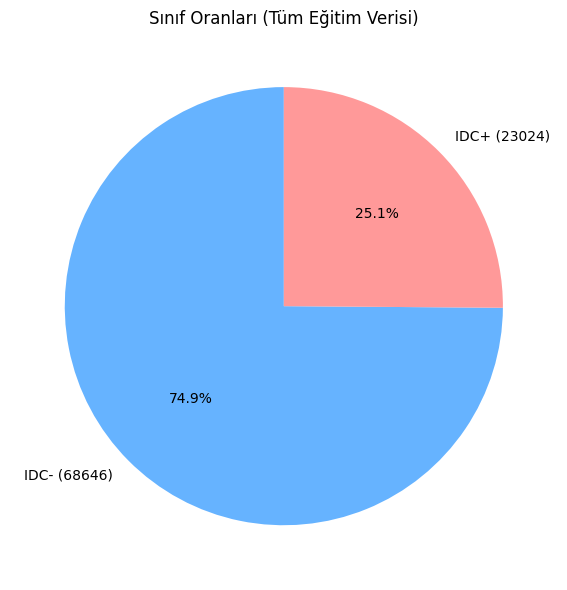


Görüntülerdeki Dengesizlik Oranı!!!: 1:2.98


In [ ]:
# VERİ HAZIRLIĞI
print("\n## 3. Veri Hazırlığı ve Bölümleme 🏗️")

# Ham görüntü yollarını alıp işler ve sayısal değerlere çevirir
def load_and_prepare_data(image_paths, width, height):
    """Tüm görüntüleri yükler, normalize eder ve etiketleri çıkarır."""
    X_data = []; Y_labels = []
    print(f"Tüm {len(image_paths)} etiketli görüntü RAM'e yükleniyor ayrıca görüntüler {width}x{height} boyutuna işleniyor...")
    for i, img_path in enumerate(image_paths):
        if i % 5000 == 0 and i > 0: print(f"    --> {i} görüntü yüklendi...")
        img = cv2.imread(img_path) # Görüntüyü oku ve piksel verileri belleğe al
        if img is None: continue # Görüntü okunamadıysa atla
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR'den RGB'ye dönüştür
        img_resized = cv2.resize(img_rgb, (width, height), interpolation=cv2.INTER_CUBIC) # Boyutlandır
        X_data.append(img_resized / 255.0) # piksel verilerini Normalleştir ve listeye ekle
        Y_labels.append(int(img_path.split('class')[-1][0])) # Etiketi al
    return np.array(X_data, dtype='float32'), np.array(Y_labels)

# Görüntüleri yükle ve hazırla
X, Y = load_and_prepare_data(train_only_paths, IMG_WIDTH, IMG_HEIGHT)

# Sınıf sayımlarını bul
count_zero = np.sum(Y == 0)
count_one = np.sum(Y == 1)

# Pasta grafiği çiz
plt.figure(figsize=(7, 6))
plt.pie([count_zero, count_one], labels=[f'IDC- ({count_zero})', f'IDC+ ({count_one})'],
        colors=['#66b3ff','#ff9999'], autopct='%1.1f%%', startangle=90)
plt.title('Sınıf Oranları (Tüm Eğitim Verisi)'); plt.tight_layout(); plt.show()

# Dengesizlik oranını yazdır
print(f"\nGörüntülerdeki Dengesizlik Oranı!!!: 1:{count_zero/count_one:.2f}")

In [ ]:
# VERİ BÖLÜMLEME
# stratify = Y parametresi, 0 ve 1 lerin eğitim, val ve testte de aynı oranda olmasını sağlar
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, test_size=TEST_RATIO + VALIDATION_RATIO, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, test_size=TEST_RATIO / (TEST_RATIO + VALIDATION_RATIO), random_state=42, stratify=Y_rem)

# Etiketleri one-hot encoding formatına dönüştür (1 sınıfı 0 dan üstün değildir)
Y_trainHot, Y_valHot, Y_testHot = to_categorical(Y_train, NUM_CLASSES), to_categorical(Y_val, NUM_CLASSES), to_categorical(Y_test, NUM_CLASSES)

# Sınıf Dengesizliğini gidermek için Sınıf Ağırlıkları hesapla
class_weights_full = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weight_dict = dict(enumerate(class_weights_full))
print(f"Eğitim Verisi: {len(X_train)} | Sınıf Ağırlıkları: {class_weight_dict}")
# Bellekten yer açmak için orijinal veriyi sil
del X, Y

# Veri Artırma (Data Augmentation) Tanımı
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    horizontal_flip=True, vertical_flip=True, zoom_range=0.1, fill_mode='nearest'
)
datagen.fit(X_train) # Eğitim verisi üzerinde veri arttırma yapılcak

Eğitim Verisi: 64168 | Sınıf Ağırlıkları: {0: np.float64(0.6677072277371959), 1: np.float64(1.9906930570205372)}


In [ ]:
print("\n## 4. Çoklu Model Tanımı 🧠")

# Derin öğrenme Modellerimizin ayarları değişir (giriş: temel modelin girişi, çıkış: yeni  katmanlar)
def build_custom_head(base_model, num_classes=2):
    # Temel modelin çıkış katmanını al
    x = base_model.output
    # Global Ortalama Havuzlama (Global Average Pooling) katmanı ekle
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Tam Bağlantılı (Fully Connected-aktivason fonk.) katman ekle
    x = Dense(512, activation='relu', name='fc1_custom')(x)
    x = Dropout(0.5, name='dropout_1')(x) # Aşırı öğrenmeyi engellemek için Dropout
    x = Dense(256, activation='relu', name='fc2_custom')(x)
    x = Dropout(0.4, name='dropout_2')(x)
    # Çıkış katmanı (softmax, çoklu sınıflandırma için)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    return Model(inputs=base_model.input, outputs=predictions)

def define_model(model_name, input_shape, weights='imagenet'):
    """Seçilen mimariyi yükler ve yeni temel modeli oluşturur."""
    print(f"\n--- Model Yükleniyor: {model_name} ---")

    # Model ismine göre önceden eğitilmiş ağırlıklarla temel modeli yükle
    if model_name == 'VGG16':
        base = VGG16(weights=weights, include_top=False, input_tensor=Input(shape=input_shape))
        last_conv_layer_name = 'block5_conv3'
    elif model_name == 'ResNet50':
        base = ResNet50(weights=weights, include_top=False, input_tensor=Input(shape=input_shape))
        last_conv_layer_name = 'conv5_block3_out'
    else:
        raise ValueError(f"Bilinmeyen model: {model_name}")

    # Temel modelin üzerine özel sınıflandırma başlığını ekleyen fonk. çalıştır
    model = build_custom_head(base, NUM_CLASSES)

    # Temel model katmanlarını dondur (Öznitelik Çıkarma için)
    for layer in base.layers:
        layer.trainable = False

    # Modeli derle çalışır hale getir(loss fonksiyonu, optimizer ve metrikler belirtilir)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model, last_conv_layer_name

MODELS_TO_TRAIN = ['VGG16', 'ResNet50']
ALL_MODEL_RESULTS = {}


## 4. Çoklu Model Tanımı 🧠


In [ ]:
print("\n## 5. Eğitim ve İnce Ayar Döngüsü Başlıyor 🔄")

BATCH_SIZE = 32 # Tek bir eğitim adımında işlenecek örnek sayısı
EPOCHS_FE = 35  # Öznitelik Çıkarma aşamasındaki epoch sayısı
EPOCHS_FT = 35  # İnce Ayar aşamasındaki epoch sayısı

# XLA_FLAGS'ı ayarlayarak CUDNN algoritma seçimi hatalarını göz ardı et
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

# Belirlenen her bir model için eğitim ve ince ayar döngüsünü başlat
for model_name in MODELS_TO_TRAIN:
    # Modeli tanımla ve son evrişim katmanının adını al
    model, last_conv_layer_name = define_model(model_name, (IMG_WIDTH, IMG_HEIGHT, CHANNELS))
    # Model ağırlıklarının kaydedileceği yolları belirle
    model_save_path_fe = os.path.join(MODEL_DIR, f'{model_name}_fe_best.h5')
    model_save_path_ft = os.path.join(MODEL_DIR, f'{model_name}_ft_best.h5')

    print(f"\n[{model_name}] --- 5.1. Temel Eğitim (Feature Extraction) ---")

    # - Temel Eğitim (Öznitelik Çıkarma) Temel model katmanları dondurulur, sadece üst katmanlar eğitilir
    # Modelin en iyi ağırlıklarını kaydetmek için ModelCheckpoint callback'i
    checkpoint_fe = ModelCheckpoint(model_save_path_fe, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
    # Aşırı öğrenmeyi durdurmak için EarlyStopping callback'i
    early_stopping_fe = EarlyStopping(monitor='val_loss', patience=12, mode='min', verbose=1)

    history_fe = model.fit(
        datagen.flow(X_train, Y_trainHot, batch_size=BATCH_SIZE), # Veri artırma ile eğitim verisi akışı
        steps_per_epoch=math.ceil(len(X_train) / BATCH_SIZE), # Her epoch'ta kaç adım çalışılacağını belirle
        epochs=EPOCHS_FE, validation_data=(X_val, Y_valHot), # Epoch sayısı ve doğrulama verisi
        class_weight=class_weight_dict, # Sınıf dengesizliğini gidermek için sınıf ağırlıkları
        callbacks=[checkpoint_fe, early_stopping_fe],
        verbose=1 # Eğitimi konsola yazdır
    )

    try: model = load_model(model_save_path_fe) # En iyi öznitelik çıkarma modelini yükle
    except: pass


    print(f"\n[{model_name}] --- 5.2. İnce Ayar (Fine-Tuning) ---")

    # - İnce Ayar Hazırlığı Modelin tamamı veya belirli katmanları eğitilebilir hale getirilir
    model.trainable = True # Modelin tüm katmanlarını eğitilebilir yap

    for layer in model.layers:
        # Bazı ilk konvolüsyon bloklarını dondur, geri kalanları aç
        if model_name == 'VGG16' and layer.name.startswith('block1'): layer.trainable = False
        elif model_name == 'ResNet50' and layer.name.startswith('conv1'): layer.trainable = False
        # Özel katmanları (fc, dropout, global pooling) her zaman açık tut
        elif layer.name.startswith('fc') or layer.name.startswith('dropout') or layer.name.startswith('global'):
             layer.trainable = True
        else:
            layer.trainable = True # Kalan tüm evrişimsel katmanlar ince ayar için açılır.

    # Modeli yeniden derle
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

    # --- İnce Ayar Eğitimi ---
    # İnce ayar sonrası en iyi ağırlıkları kaydetmek için ModelCheckpoint callback'i
    checkpoint_ft = ModelCheckpoint(model_save_path_ft, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
    # Aşırı öğrenmeyi durdurmak için EarlyStopping callback'i
    early_stopping_ft = EarlyStopping(monitor='val_loss', patience=17, mode='min', verbose=1)

    history_ft = model.fit(
        datagen.flow(X_train, Y_trainHot, batch_size=BATCH_SIZE),
        steps_per_epoch=math.ceil(len(X_train) / BATCH_SIZE),
        epochs=EPOCHS_FT, validation_data=(X_val, Y_valHot),
        class_weight=class_weight_dict,
        callbacks=[checkpoint_ft, early_stopping_ft],
        verbose=1
    )

    # - Test ve Sonuç Kaydı
    final_model = load_model(model_save_path_ft) # En iyi ince ayar modelini yükle
    Y_pred = final_model.predict(X_test) # Test seti üzerinde tahmin yap
    Y_pred_classes = np.argmax(Y_pred, axis=1) # Tahmin edilen sınıf etiketlerini olasılık şeklinde al
    Y_true_labels = np.argmax(Y_testHot, axis=1) # hot'tan gerçeğe çevir

    # Sınıflandırma raporunu oluştur ve AUC değerini hesapla
    report = classification_report(Y_true_labels, Y_pred_classes, output_dict=True, zero_division=0)
    roc_auc = auc(roc_curve(Y_true_labels, Y_pred[:, 1])[0], roc_curve(Y_true_labels, Y_pred[:, 1])[1])

    # Model sonuçlarını kaydet
    ALL_MODEL_RESULTS[model_name] = {
        'Accuracy': report['accuracy'],
        'Recall_IDC+': report['1']['recall'],
        'Precision_IDC+': report['1']['precision'],
        'F1_IDC+': report['1']['f1-score'],
        'Recall_IDC-': report['0']['recall'],
        'Precision_IDC-': report['0']['precision'],
        'F1_IDC-': report['0']['f1-score'],
        'AUC': roc_auc,
        'Model_Path': model_save_path_ft,
        'Last_Conv_Layer': last_conv_layer_name,
        'History_FE': history_fe.history,
        'History_FT': history_ft.history
    }
    print(f"[{model_name}] Test Sonuçları Kaydedildi.")


## 5. Eğitim ve İnce Ayar Döngüsü Başlıyor 🔄

--- Model Yükleniyor: VGG16 ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

[VGG16] --- 5.1. Temel Eğitim (Feature Extraction) ---
Epoch 1/35


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7153 - loss: 0.5731

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 173s 82ms/step - accuracy: 0.7153 - loss: 0.5730 - val_accuracy: 0.7675 - val_loss: 0.5181
Epoch 2/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8049 - loss: 0.4652

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8049 - loss: 0.4652 - val_accuracy: 0.8020 - val_loss: 0.4580
Epoch 3/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 159s 79ms/step - accuracy: 0.8142 - loss: 0.4495 - val_accuracy: 0.7889 - val_loss: 0.4764
Epoch 4/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8158 - loss: 0.4351

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8158 - loss: 0.4351 - val_accuracy: 0.8172 - val_loss: 0.4200
Epoch 5/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8159 - loss: 0.4335

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 159s 79ms/step - accuracy: 0.8159 - loss: 0.4335 - val_accuracy: 0.8261 - val_loss: 0.4065
Epoch 6/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8218 - loss: 0.4228 - val_accuracy: 0.7937 - val_loss: 0.4600
Epoch 7/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8238 - loss: 0.4206 - val_accuracy: 0.8149 - val_loss: 0.4193
Epoch 8/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 159s 79ms/step - accuracy: 0.8200 - loss: 0.4170 - val_accuracy: 0.8183 - val_loss: 0.4120
Epoch 9/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8179 - loss: 0.4195 - val_accuracy: 0.8141 - val_loss: 0.4142
Epoch 10/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 161s 80ms/step - accuracy: 0.8237 - loss: 0.4141 - val_accuracy: 0.8259 - val_loss: 0.3971
Epoch 11/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8270 - loss: 0.4124 - val_accuracy: 0.8160 - val_loss: 0.4146
Epoch 12/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.8254 -

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8287 - loss: 0.4076 - val_accuracy: 0.8399 - val_loss: 0.3655
Epoch 19/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.8302 - loss: 0.4012 - val_accuracy: 0.8165 - val_loss: 0.4249
Epoch 20/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 159s 79ms/step - accuracy: 0.8319 - loss: 0.4009 - val_accuracy: 0.8246 - val_loss: 0.3961
Epoch 21/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8303 - loss: 0.4007 - val_accuracy: 0.8054 - val_loss: 0.4357
Epoch 22/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8302 - loss: 0.4007 - val_accuracy: 0.8344 - val_loss: 0.3774
Epoch 23/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8317 - loss: 0.3979 - val_accuracy: 0.8284 - val_loss: 0.3961
Epoch 24/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8290 - loss: 0.4018 - val_accuracy: 0.8297 - val_loss: 0.3850
Epoch 25/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.83

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8348 - loss: 0.3964 - val_accuracy: 0.8414 - val_loss: 0.3640
Epoch 27/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8282 - loss: 0.4041

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 159s 79ms/step - accuracy: 0.8282 - loss: 0.4041 - val_accuracy: 0.8467 - val_loss: 0.3577
Epoch 28/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8321 - loss: 0.3967 - val_accuracy: 0.8263 - val_loss: 0.3993
Epoch 29/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 158s 79ms/step - accuracy: 0.8355 - loss: 0.3904 - val_accuracy: 0.8308 - val_loss: 0.3935
Epoch 30/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8328 - loss: 0.3971 - val_accuracy: 0.8420 - val_loss: 0.3671
Epoch 31/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 161s 80ms/step - accuracy: 0.8342 - loss: 0.3952 - val_accuracy: 0.8428 - val_loss: 0.3672
Epoch 32/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 157s 78ms/step - accuracy: 0.8318 - loss: 0.3955 - val_accuracy: 0.8331 - val_loss: 0.3770
Epoch 33/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 162s 81ms/step - accuracy: 0.8369 - loss: 0.3887 - val_accuracy: 0.8244 - val_loss: 0.4010
Epoch 34/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.83

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 168s 84ms/step - accuracy: 0.8375 - loss: 0.3867 - val_accuracy: 0.8515 - val_loss: 0.3476



[VGG16] --- 5.2. İnce Ayar (Fine-Tuning) ---
Epoch 1/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8308 - loss: 0.3944

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 261s 123ms/step - accuracy: 0.8308 - loss: 0.3944 - val_accuracy: 0.8738 - val_loss: 0.3034
Epoch 2/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8698 - loss: 0.3144

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 238s 119ms/step - accuracy: 0.8698 - loss: 0.3144 - val_accuracy: 0.8943 - val_loss: 0.2535
Epoch 3/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 237s 118ms/step - accuracy: 0.8730 - loss: 0.3038 - val_accuracy: 0.8722 - val_loss: 0.3006
Epoch 4/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 237s 118ms/step - accuracy: 0.8819 - loss: 0.2861 - val_accuracy: 0.8934 - val_loss: 0.2605
Epoch 5/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8855 - loss: 0.2808

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 237s 118ms/step - accuracy: 0.8855 - loss: 0.2808 - val_accuracy: 0.8972 - val_loss: 0.2545
Epoch 6/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 237s 118ms/step - accuracy: 0.8885 - loss: 0.2706 - val_accuracy: 0.8906 - val_loss: 0.2586
Epoch 7/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8891 - loss: 0.2674

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.8891 - loss: 0.2674 - val_accuracy: 0.9020 - val_loss: 0.2307
Epoch 8/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.8959 - loss: 0.2538 - val_accuracy: 0.8964 - val_loss: 0.2428
Epoch 9/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8955 - loss: 0.2556

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 237s 118ms/step - accuracy: 0.8955 - loss: 0.2556 - val_accuracy: 0.9175 - val_loss: 0.1993
Epoch 10/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9004 - loss: 0.2473 - val_accuracy: 0.8990 - val_loss: 0.2330
Epoch 11/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9003 - loss: 0.2428 - val_accuracy: 0.9134 - val_loss: 0.2109
Epoch 12/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9022 - loss: 0.2323 - val_accuracy: 0.9023 - val_loss: 0.2227
Epoch 13/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9023 - loss: 0.2346 - val_accuracy: 0.8910 - val_loss: 0.2572
Epoch 14/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9028 - loss: 0.2280 - val_accuracy: 0.8946 - val_loss: 0.2398
Epoch 15/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9069 - loss: 0.2231 - val_accuracy: 0.9075 - val_loss: 0.2166
Epoch 16/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accura

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 237s 118ms/step - accuracy: 0.9205 - loss: 0.1930 - val_accuracy: 0.9181 - val_loss: 0.1998
Epoch 26/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 236s 118ms/step - accuracy: 0.9209 - loss: 0.1864 - val_accuracy: 0.9000 - val_loss: 0.2349
Epoch 26: early stopping


573/573 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step
[VGG16] Test Sonuçları Kaydedildi.

--- Model Yükleniyor: ResNet50 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

[ResNet50] --- 5.1. Temel Eğitim (Feature Extraction) ---
Epoch 1/35


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5204 - loss: 0.7225

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 179s 83ms/step - accuracy: 0.5204 - loss: 0.7225 - val_accuracy: 0.6770 - val_loss: 0.6659
Epoch 2/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5612 - loss: 0.6790

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 152s 76ms/step - accuracy: 0.5612 - loss: 0.6790 - val_accuracy: 0.6997 - val_loss: 0.5975
Epoch 3/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 151s 75ms/step - accuracy: 0.6412 - loss: 0.6381 - val_accuracy: 0.5881 - val_loss: 0.6790
Epoch 4/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 151s 75ms/step - accuracy: 0.6697 - loss: 0.6198 - val_accuracy: 0.6308 - val_loss: 0.6592
Epoch 5/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 151s 75ms/step - accuracy: 0.6831 - loss: 0.6100 - val_accuracy: 0.5973 - val_loss: 0.6949
Epoch 6/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6855 - loss: 0.6090

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 151s 75ms/step - accuracy: 0.6855 - loss: 0.6090 - val_accuracy: 0.7309 - val_loss: 0.5609
Epoch 7/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 153s 76ms/step - accuracy: 0.6963 - loss: 0.6015 - val_accuracy: 0.7301 - val_loss: 0.5669
Epoch 8/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 153s 76ms/step - accuracy: 0.7019 - loss: 0.5946 - val_accuracy: 0.6587 - val_loss: 0.6385
Epoch 9/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 152s 76ms/step - accuracy: 0.6974 - loss: 0.5953 - val_accuracy: 0.6307 - val_loss: 0.6774
Epoch 10/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 153s 76ms/step - accuracy: 0.7026 - loss: 0.5919 - val_accuracy: 0.6892 - val_loss: 0.6039
Epoch 11/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 154s 77ms/step - accuracy: 0.7052 - loss: 0.5952 - val_accuracy: 0.6784 - val_loss: 0.6134
Epoch 12/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - accuracy: 0.7034 - loss: 0.5959 - val_accuracy: 0.7166 - val_loss: 0.5701
Epoch 13/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 155s 77ms/step - accuracy: 0.7074 


[ResNet50] --- 5.2. İnce Ayar (Fine-Tuning) ---
Epoch 1/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7889 - loss: 4.3315

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 247s 97ms/step - accuracy: 0.7888 - loss: 4.3302 - val_accuracy: 0.8741 - val_loss: 0.3352
Epoch 2/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 166s 83ms/step - accuracy: 0.8180 - loss: 0.4215 - val_accuracy: 0.8739 - val_loss: 0.3167
Epoch 3/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8450 - loss: 0.3640 - val_accuracy: 0.8079 - val_loss: 0.5140
Epoch 4/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8615 - loss: 0.3260 - val_accuracy: 0.7439 - val_loss: 0.8795
Epoch 5/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 166s 83ms/step - accuracy: 0.8681 - loss: 0.3132 - val_accuracy: 0.8020 - val_loss: 0.6368
Epoch 6/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 165s 82ms/step - accuracy: 0.8762 - loss: 0.2931 - val_accuracy: 0.7312 - val_loss: 0.7238
Epoch 7/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8775 - loss: 0.2916 - val_accuracy: 0.8372 - val_loss: 0.3831
Epoch 8/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8838 - loss

2006/2006 ━━━━━━━━━━━━━━━━━━━━ 165s 82ms/step - accuracy: 0.8838 - loss: 0.2834 - val_accuracy: 0.8769 - val_loss: 0.3122
Epoch 9/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8850 - loss: 0.2744 - val_accuracy: 0.8176 - val_loss: 0.4152
Epoch 10/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 163s 81ms/step - accuracy: 0.8917 - loss: 0.2601 - val_accuracy: 0.7489 - val_loss: 1.6118
Epoch 11/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8898 - loss: 0.2579 - val_accuracy: 0.8195 - val_loss: 0.9298
Epoch 12/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 165s 82ms/step - accuracy: 0.8921 - loss: 0.2532 - val_accuracy: 0.7489 - val_loss: 2.6204
Epoch 13/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.8919 - loss: 0.2533 - val_accuracy: 0.7782 - val_loss: 0.4933
Epoch 14/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 165s 82ms/step - accuracy: 0.8988 - loss: 0.2404 - val_accuracy: 0.8407 - val_loss: 0.3660
Epoch 15/35
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 164s 82ms/step - accuracy: 0.899

573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step
[ResNet50] Test Sonuçları Kaydedildi.



--- Eğitim Geçmişi Grafikleri Başlıyor ---


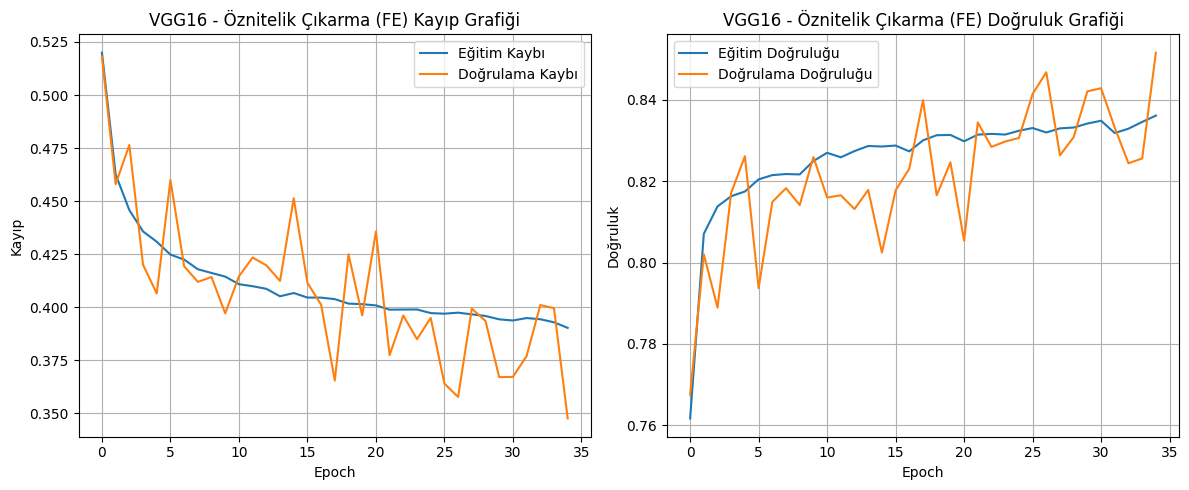

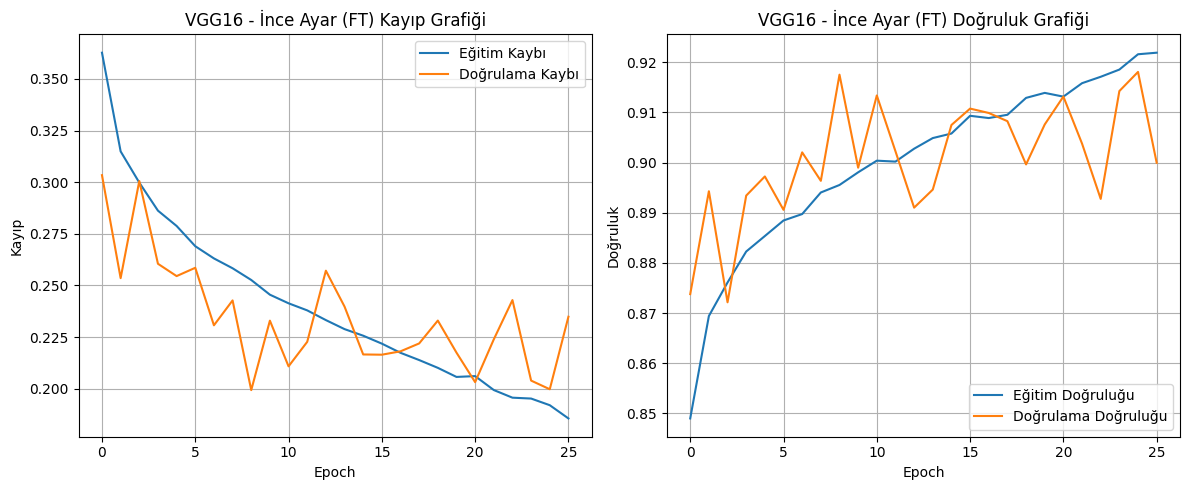

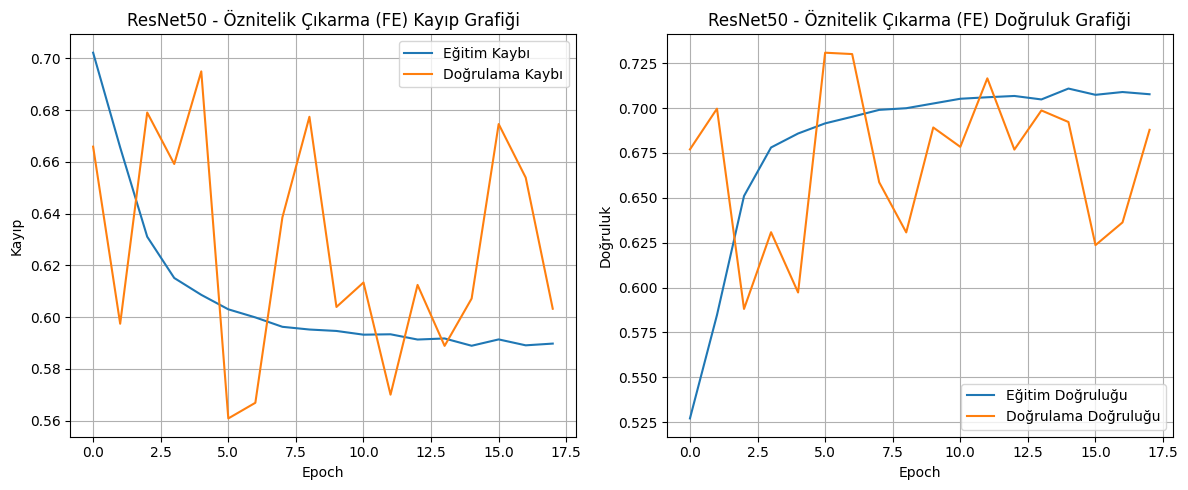

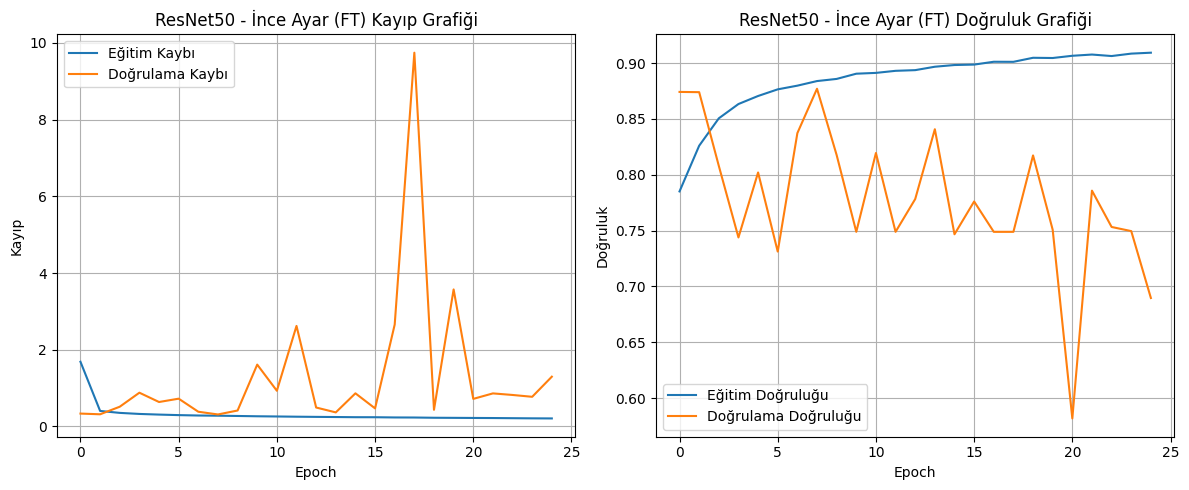

In [ ]:
def plot_history(history, model_name, phase):
    """Eğitim ve doğrulama metriklerini grafikler."""
    plt.figure(figsize=(12, 5))

    # Kayıp (Loss) Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Eğitim Kaybı')
    plt.plot(history['val_loss'], label='Doğrulama Kaybı')
    plt.title(f'{model_name} - {phase} Kayıp Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)

    # Doğruluk (Accuracy) Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title(f'{model_name} - {phase} Doğruluk Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- Eğitim Geçmişi Grafikleri Başlıyor ---")
for model_name, results in ALL_MODEL_RESULTS.items():
    if 'History_FE' in results:
        plot_history(results['History_FE'], model_name, "Öznitelik Çıkarma (FE)")
    if 'History_FT' in results:
        plot_history(results['History_FT'], model_name, "İnce Ayar (FT)")


## Karşılaştırmalı Değerlendirme Sonuçları 📊

--- İki Model Performans Tablosu (VGG16 vs ResNet50) ---
          Accuracy Recall_IDC+ Precision_IDC+   F1_IDC+ Recall_IDC-  \
VGG16     0.919989    0.888165       0.811186  0.847932    0.930663   
ResNet50  0.875648    0.750706       0.753323  0.752012    0.917553   

         Precision_IDC-   F1_IDC-       AUC  \
VGG16          0.961258  0.945713  0.969401   
ResNet50       0.916485  0.917018   0.91828   

                                   Model_Path   Last_Conv_Layer  \
VGG16        /content/models/VGG16_ft_best.h5      block5_conv3   
ResNet50  /content/models/ResNet50_ft_best.h5  conv5_block3_out   

                                                 History_FE  \
VGG16     {'accuracy': [0.7617192268371582, 0.8070689439...   
ResNet50  {'accuracy': [0.5270695686340332, 0.5846995115...   

                                                 History_FT  
VGG16     {'accuracy': [0.8490057587623596, 0.8694208860...  
ResNet50  {'accuracy': [

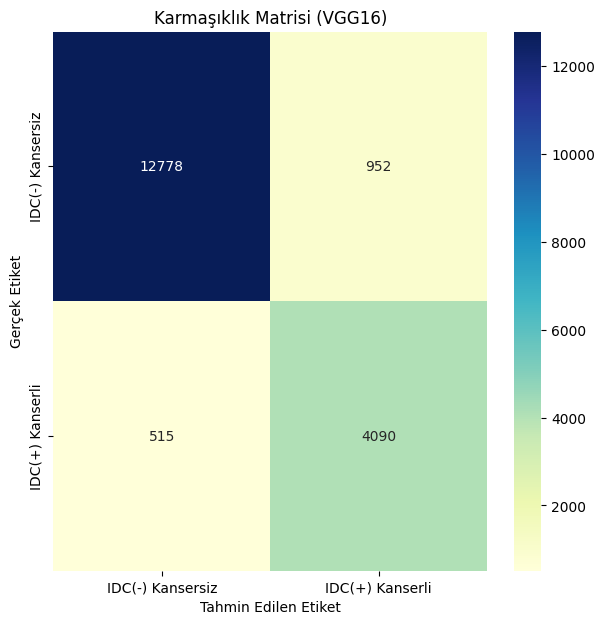

In [ ]:
print("\n## Karşılaştırmalı Değerlendirme Sonuçları 📊")

# Tüm model sonuçlarını bir DataFrame'e dönüştür ve AUC'ye göre sırala
results_df = pd.DataFrame(ALL_MODEL_RESULTS).T.sort_values(by='AUC', ascending=False)
# En iyi modeli belirle
best_model_name = results_df.index[0]
best_model_path = ALL_MODEL_RESULTS[best_model_name]['Model_Path']
best_conv_layer = ALL_MODEL_RESULTS[best_model_name]['Last_Conv_Layer']

print("\n--- İki Model Performans Tablosu (VGG16 vs ResNet50) ---")
# Artık 'Recall_IDC-', 'Precision_IDC-' ve 'F1_IDC-' metrikleri de tabloda yer almaktadır.
print(results_df.round(4))
print(f"\nEn Yüksek Performansa Sahip Model: **{best_model_name}** (AUC: {results_df['AUC'].max():.4f})")

# En iyi modelin yüklenmesi ve tahminlerin yeniden hesaplanması
best_model = load_model(best_model_path)
Y_pred_best = best_model.predict(X_test, verbose=0) # Tahmin olasılıkları
Y_pred_classes_best = np.argmax(Y_pred_best, axis=1) # Tahmin edilen sınıf etiketleri
Y_true_labels = np.argmax(Y_testHot, axis=1) # Gerçek sınıf etiketleri

# Etiket haritası tanımla
map_characters = {0: 'IDC(-) Kansersiz', 1: 'IDC(+) Kanserli'}

# Karmaşıklık Matrisi (Confusion Matrix) çizimi
conf_mat = confusion_matrix(Y_true_labels, Y_pred_classes_best)
plt.figure(figsize = (7,7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu",
             xticklabels=list(map_characters.values()),
             yticklabels=list(map_characters.values()))
plt.title(f'Karmaşıklık Matrisi ({best_model_name})'); plt.ylabel('Gerçek Etiket'); plt.xlabel('Tahmin Edilen Etiket');
plt.show()

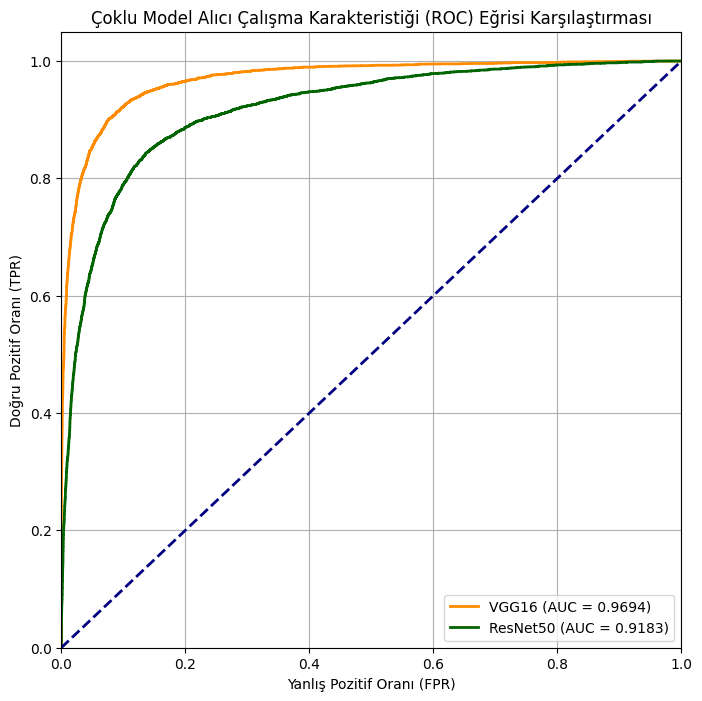

In [ ]:
# ÇOKLU ROC EĞRİSİ KARŞILAŞTIRMASI - Receiver Operating Characteristic Curve

plt.figure(figsize=(8, 8))
colors = ['darkorange', 'darkgreen', 'darkred', 'darkblue'] # VGG16 ve ResNet50 için renkler

# Her bir model için ROC eğrisini çizme döngüsü
for i, model_name in enumerate(MODELS_TO_TRAIN):
    model_path = ALL_MODEL_RESULTS[model_name]['Model_Path']

    try:
        current_model = load_model(model_path)
        # Tahmin olasılıkları yeniden hesaplanıyor
        Y_pred_current = current_model.predict(X_test, verbose=0)

        # ROC eğrisi ve AUC değerini hesapla
        fpr, tpr, _ = roc_curve(Y_true_labels, Y_pred_current[:, 1])
        auc_score = ALL_MODEL_RESULTS[model_name]['AUC']

        # ROC eğrisini çiz
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label=f'{model_name} (AUC = {auc_score:.4f})')
    except Exception as e:
        print(f"UYARI: {model_name} modelinin ROC eğrisi çizilemedi: {e}")
        continue

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Rastgele sınıflandırıcının çizgisi
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]) # Eksen limitleri
plt.xlabel('Yanlış Pozitif Oranı (FPR)'); plt.ylabel('Doğru Pozitif Oranı (TPR)'); # Eksen etiketleri
plt.title('Çoklu Model Alıcı Çalışma Karakteristiği (ROC) Eğrisi Karşılaştırması'); # Başlık
plt.legend(loc="lower right"); # Açıklama
plt.grid(True)
plt.show()


## 7. KRİTİK: Grad-CAM Yorumlanabilirliği 🔍


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 96, 96, 3))
  warnings.warn(msg)


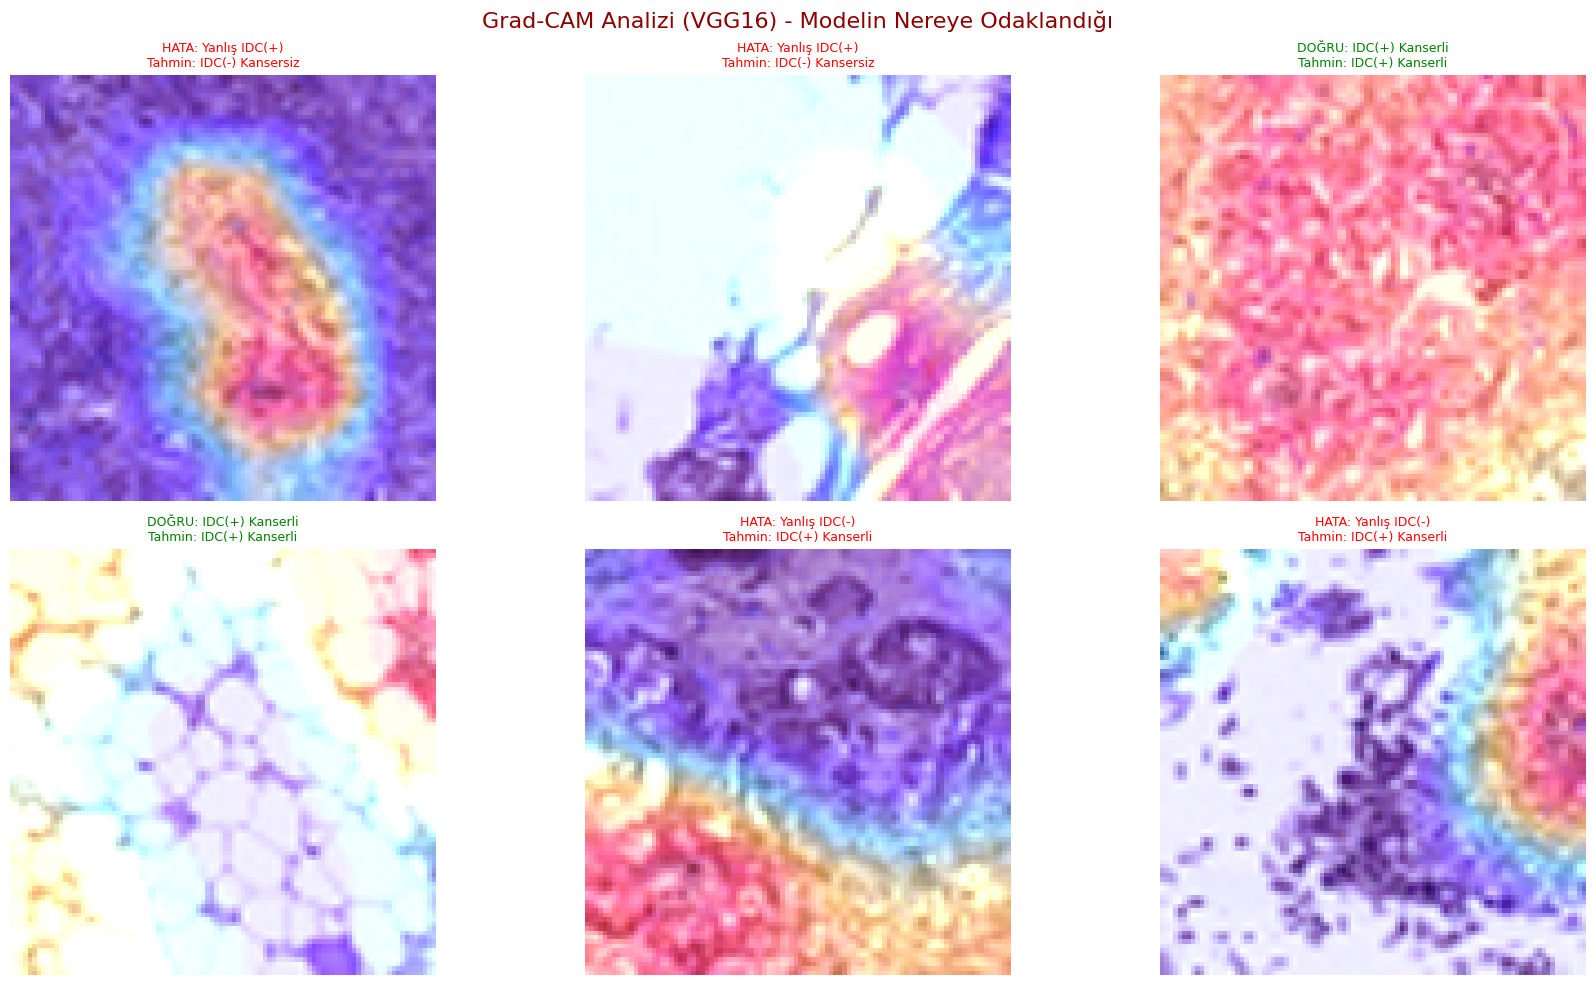

**Yorum:** Grad-CAM, VGG16 modelinin karar verirken histopatolojik dokunun hangi bölgelerine odaklandığını görselleştirmektedir.


In [ ]:
# GRAD-CAM YORUMLANABİLİRLİĞİ (En İyi Model İçin) Gradient-weighted Class Activation Mapping
print("\n## 7. KRİTİK: Grad-CAM Yorumlanabilirliği 🔍")

# GRAD-CAM FONKSİYONLARI

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """Grad-CAM haritasını oluşturur."""
    # Grad-CAM için özel bir model oluştur: Girişten son evrişim katmanının çıkışına ve nihai tahminlere kadar
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape: # Gradyanları hesaplamak için GradientTape kullan
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0]) # Tahmin edilen sınıfın indeksini al
        class_channel = preds[:, pred_index] # Tahmin edilen sınıfın skorunu al

    # Gradyanları hesapla (tahmin edilen sınıf skoru ile son evrişim katmanı çıkışı arasında)
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # Gradyanları ortalama (havuzlama) yaparak her filtre için önem ağırlığını bul
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    # Isı haritasını oluştur: evrişim katmanı çıkışını ağırlıklandırılmış gradyanlarla çarp
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap) # Fazla boyutları sıkıştır
    # Isı haritasını normalleştir (0-1 arasına) ve negatif değerleri sıfırla
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    """Görüntü ve haritayı birleştirip gösterir."""
    img = (img * 255).astype(np.uint8) # Görüntüyü 0-255 aralığına ölçekle
    heatmap = np.uint8(255 * heatmap) # Isı haritasını 0-255 aralığına ölçekle
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Isı haritasını görüntü boyutuna yeniden boyutlandır
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Isı haritasına renk haritası uygula
    superimposed_img = heatmap * alpha + img # Isı haritasını orijinal görüntü üzerine bindir
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8) # Değerleri 0-255 aralığında tut
    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB) # RGB'ye dönüştür ve döndür

# Örnek Seçimi (Grad-CAM görselleştirmesi için)
# 2 Yanlış Negatif (Kanserli ama model kansersiz dedi) örneği seç
YN_indices = np.where((Y_true_labels == 1) & (Y_pred_classes_best == 0))[0]
# 2 Doğru Pozitif (Kanserli ve model kanserli dedi) örneği seç
DP_indices = np.where((Y_true_labels == 1) & (Y_pred_classes_best == 1))[0]
# 2 Yanlış Pozitif (Kansersiz ama model kanserli dedi) örneği seç
YP_indices = np.where((Y_true_labels == 0) & (Y_pred_classes_best == 1))[0]

sample_indices = []
sample_indices.extend(np.random.choice(YN_indices, min(2, len(YN_indices)), replace=False)) # YN örneklerini ekle
sample_indices.extend(np.random.choice(DP_indices, min(2, len(DP_indices)), replace=False)) # DP örneklerini ekle
sample_indices.extend(np.random.choice(YP_indices, min(2, len(YP_indices)), replace=False)) # YP örneklerini ekle

plt.figure(figsize=(18, 10))
plt.suptitle(f"Grad-CAM Analizi ({best_model_name}) - Modelin Nereye Odaklandığı", fontsize=16, color='darkred')

# Seçilen örnekler için Grad-CAM haritalarını oluştur ve göster
for i, idx in enumerate(sample_indices):
    img_array = np.expand_dims(X_test[idx], axis=0) # Görüntüyü modele uygun formata getir
    heatmap = make_gradcam_heatmap(img_array, best_model, best_conv_layer) # Grad-CAM haritasını oluştur
    superimposed_img = display_gradcam(X_test[idx], heatmap, alpha=0.4) # Orijinal görüntü ile ısı haritasını birleştir

    true_label = map_characters[Y_true_labels[idx]] # Gerçek etiket
    pred_label = map_characters[Y_pred_classes_best[idx]] # Tahmin edilen etiket

    # Hata türünü ve renk kodunu belirle
    if Y_true_labels[idx] != Y_pred_classes_best[idx]:
        error_type = f"HATA: Yanlış {true_label.split(' ')[0]}"
        color = 'red'
    else:
        error_type = f"DOĞRU: {true_label}"
        color = 'green'

    plt.subplot(2, 3, i + 1) # Alt grafik oluştur
    plt.imshow(superimposed_img) # Birleştirilmiş görüntüyü göster
    plt.title(f"{error_type}\nTahmin: {pred_label}", fontsize=9, color=color) # Başlık ekle
    plt.axis('off') # Eksenleri kapat

plt.tight_layout(); plt.show()
print(f"**Yorum:** Grad-CAM, {best_model_name} modelinin karar verirken histopatolojik dokunun hangi bölgelerine odaklandığını görselleştirmektedir.")
# Kırmızı bölgelere çok fazla odaklanırken mavi bölgelere çok az odaklanmaktadır.

In [ ]:
print("\n## 8. Hasta Seviyesi Nihai Uygulama (Patch Yayılım Analizi) 🩺")

def load_new_test_images(image_paths, width, height):
    """Etiketsiz test görüntülerini yükler ve normalize eder."""
    X_new_test = []
    for img_path in image_paths:
        img = cv2.imread(img_path) # Görüntüyü oku
        if img is None: continue # Görüntü okunamadıysa atla
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR'den RGB'ye dönüştür
        img_resized = cv2.resize(img_rgb, (width, height), interpolation=cv2.INTER_CUBIC) # Boyutlandır
        X_new_test.append(img_resized / 255.0) # Normalleştir ve listeye ekle
    return np.array(X_new_test, dtype='float32')

def visualize_patient_samples(patient_patches_paths, model, patient_id, sample_count=5):
    """Belirli bir hastanın rastgele yama tahminlerini görselleştirir."""
    # Rastgele örnek yama indeksleri seç
    indices = np.random.choice(len(patient_patches_paths), min(len(patient_patches_paths), sample_count), replace=False)
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"HASTA {patient_id} - Rastgele Yama Tahmini ({best_model_name})", fontsize=16)

    for i, idx in enumerate(indices):
        path = patient_patches_paths[idx]
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        X_sample = np.expand_dims(img_resized / 255.0, axis=0) # Tek görüntü için boyutu genişlet
        Y_pred_prob = model.predict(X_sample, verbose=0) # Model tahmini yap
        pred_class = np.argmax(Y_pred_prob, axis=1)[0] # Tahmin edilen sınıf
        pred_label = "IDC(+) Kanserli" if pred_class == 1 else "IDC(-) Kansersiz" # Sınıf etiketini belirle
        color = 'red' if pred_class == 1 else 'green' # Tahmine göre renk belirle

        plt.subplot(1, len(indices), i + 1) # Alt grafik oluştur
        plt.imshow(img_resized) # Yamayı göster
        plt.title(f"{pred_label}", fontsize=9, color=color) # Başlık ekle
        plt.axis('off') # Eksenleri kapat
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()


## 8. Hasta Seviyesi Nihai Uygulama (Patch Yayılım Analizi) 🩺



--- 9 Etiketsiz Hastanın Analizi (Model: VGG16, Eşik: %15) ---
  -> Hasta 12820: Yayılım: %26.56 | Karar: POZİTİF (Kanserli)


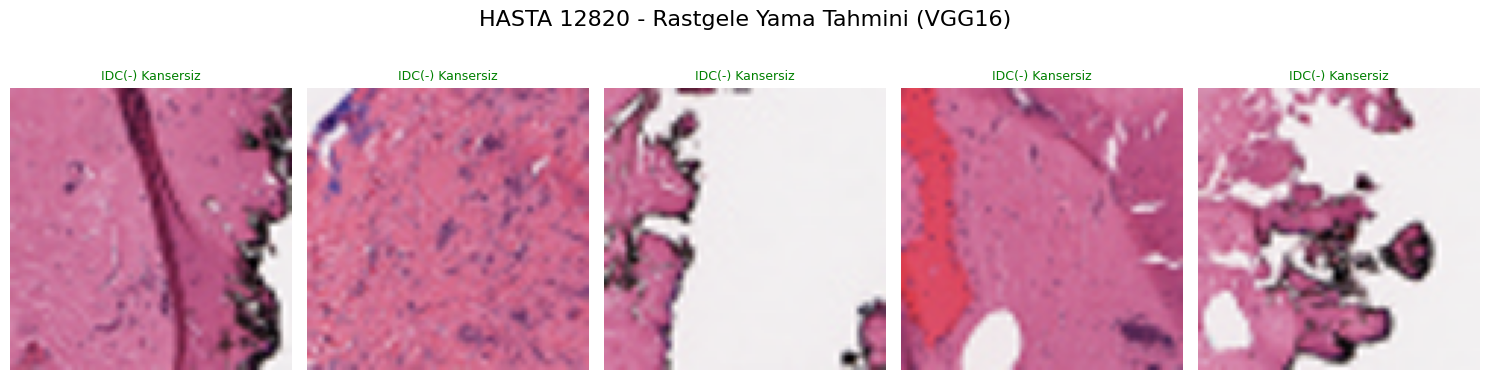

  -> Hasta 12875: Yayılım: %5.35 | Karar: NEGATİF (Kansersiz)


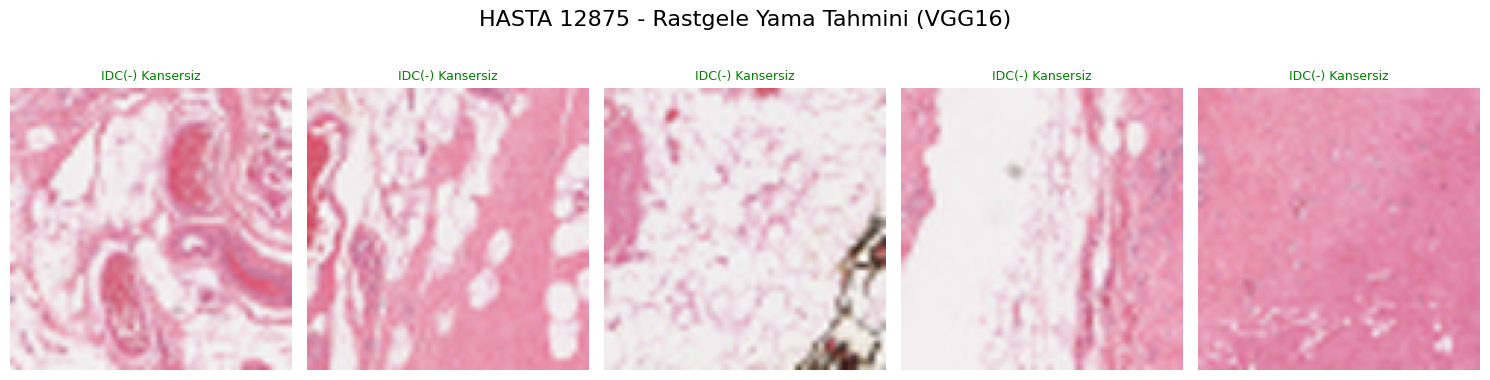

  -> Hasta 12891: Yayılım: %29.64 | Karar: POZİTİF (Kanserli)


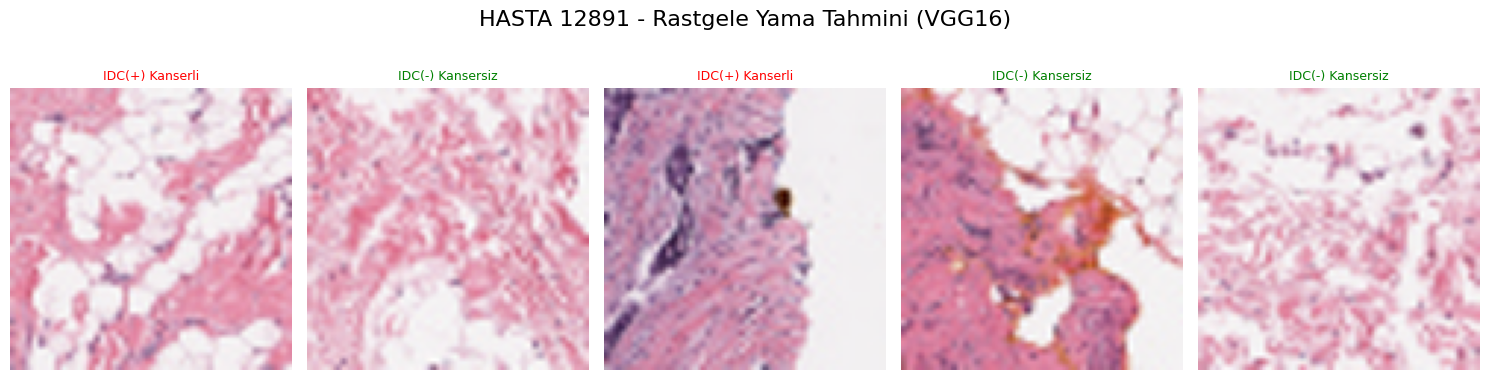

  -> Hasta 12908: Yayılım: %13.94 | Karar: NEGATİF (Kansersiz)


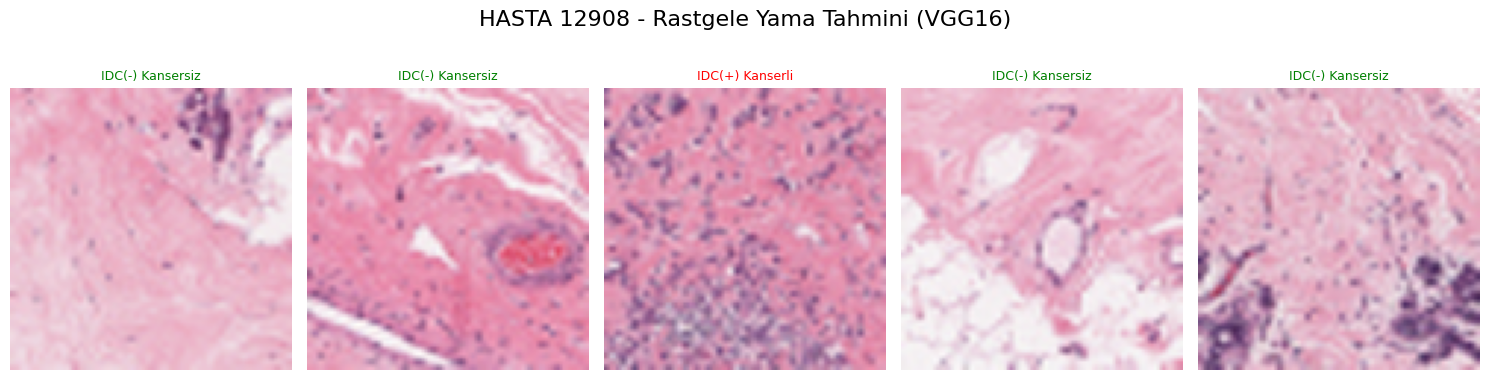

  -> Hasta 12934: Yayılım: %39.07 | Karar: POZİTİF (Kanserli)


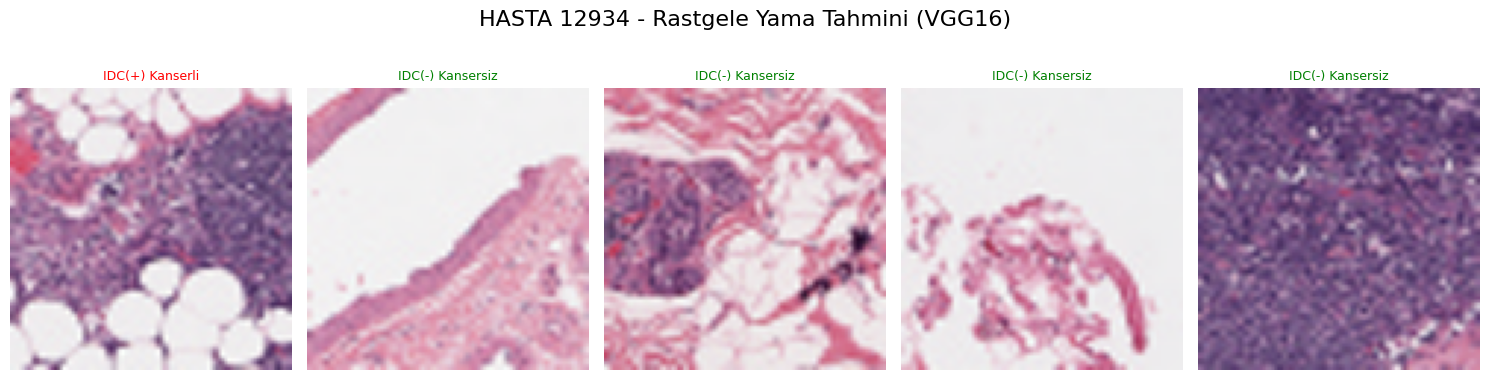

  -> Hasta 13021: Yayılım: %16.79 | Karar: POZİTİF (Kanserli)


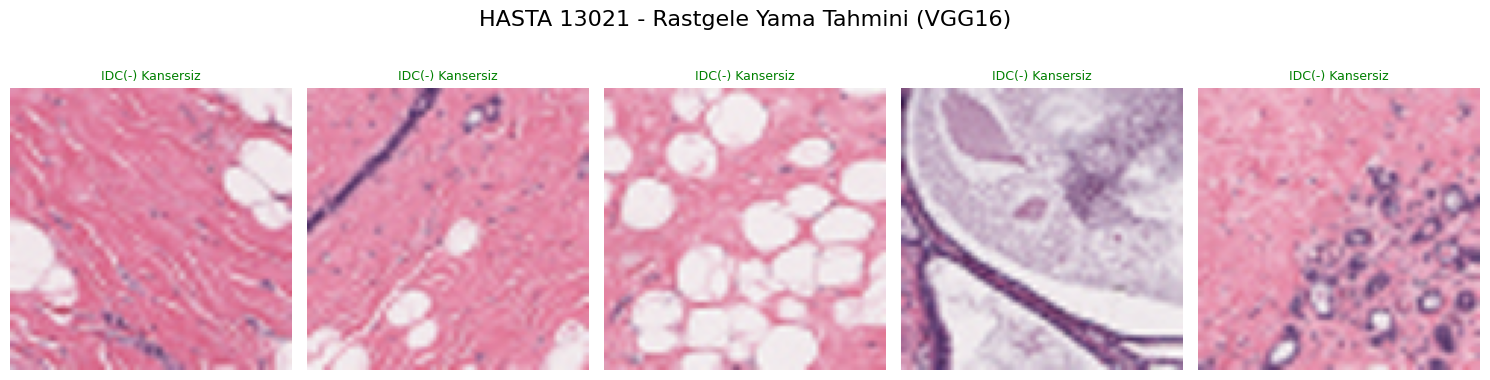

  -> Hasta 13025: Yayılım: %37.98 | Karar: POZİTİF (Kanserli)


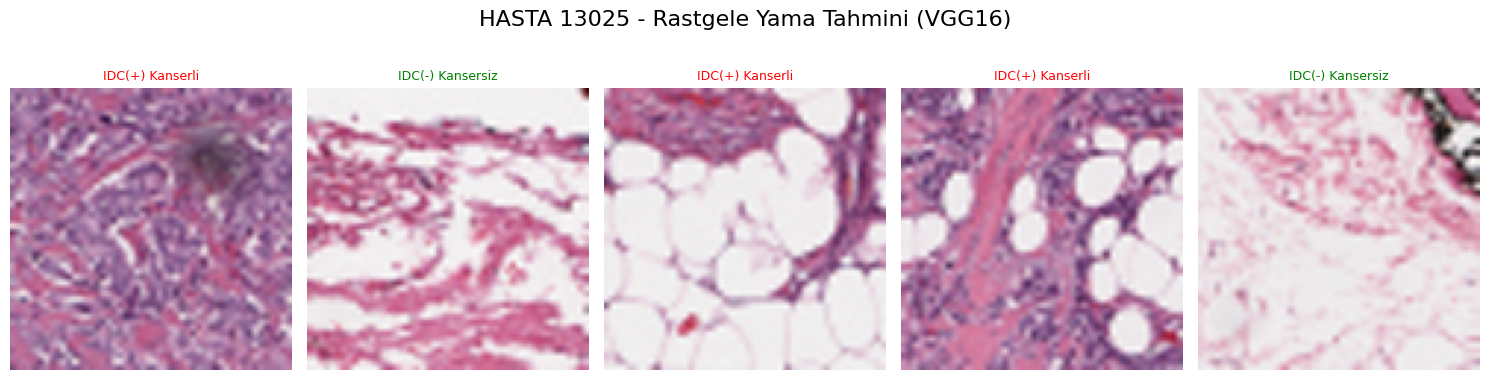

  -> Hasta 16014: Yayılım: %24.36 | Karar: POZİTİF (Kanserli)


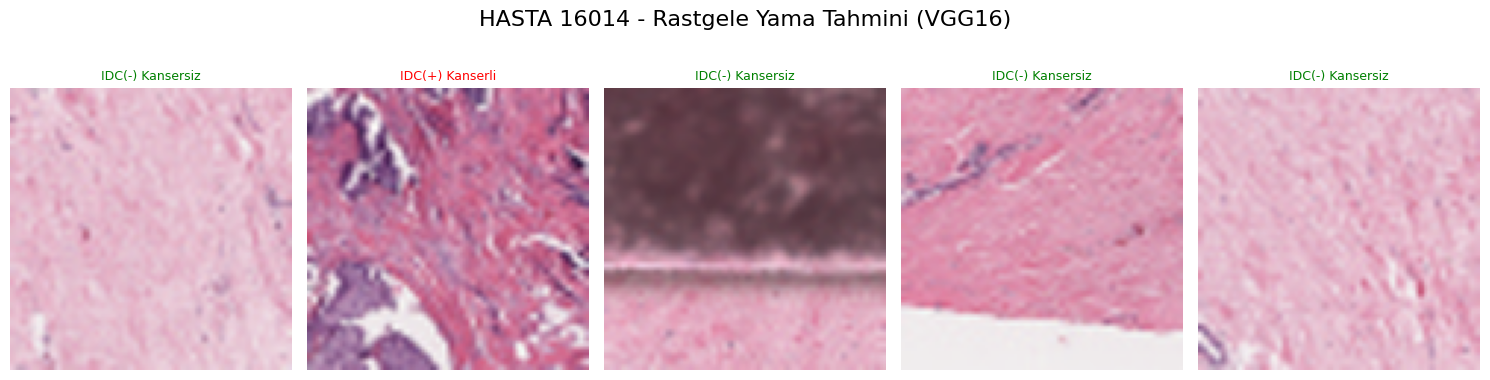

  -> Hasta 16551: Yayılım: %7.79 | Karar: NEGATİF (Kansersiz)


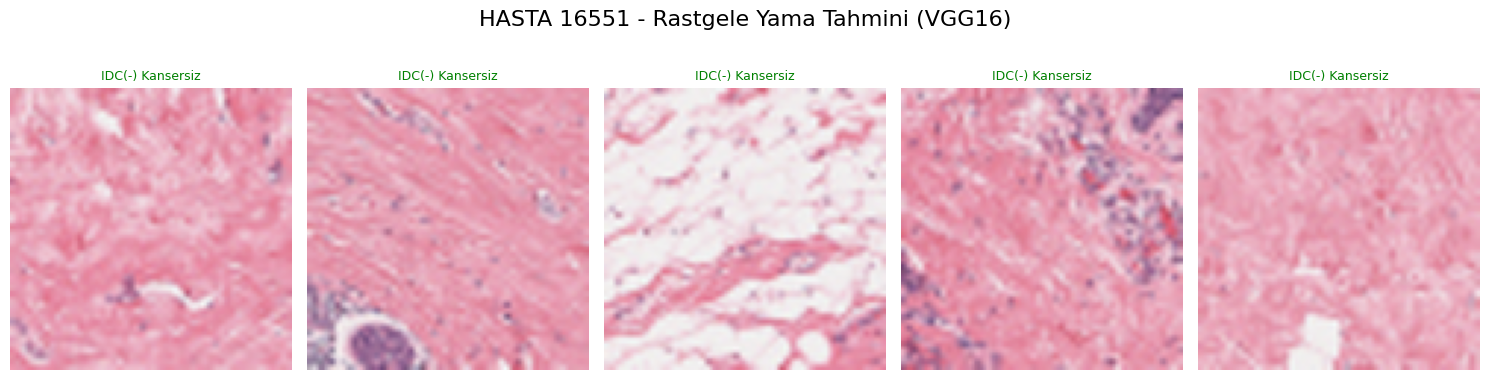

/tmp/ipython-input-1950090746.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patients, y=ratios, palette=colors) # Bar grafiği çiz


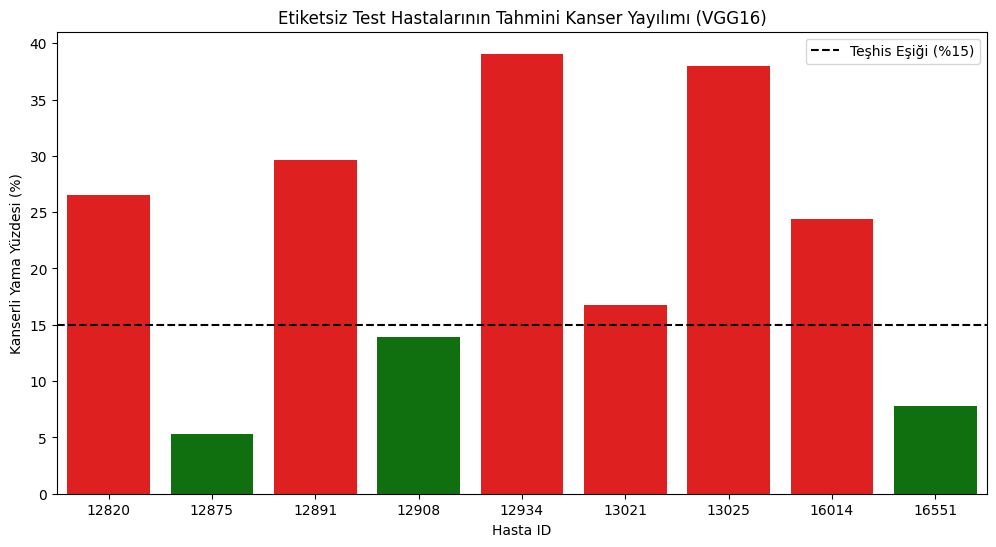


--- 🎯 Proje Başarıyla Tamamlandı ve Zenginleştirildi ---


In [ ]:
# Hastaların Analizi (Etiketsiz Test Verileri İçin)
LOCAL_TEST_DIR = os.path.join(LOCAL_DIR, 'sonTest') # Yerel test dizini yolu
new_test_image_paths = []
# Test dizinindeki tüm görüntü yollarını topla
for root, _, filenames in os.walk(LOCAL_TEST_DIR):
    for filename in fnmatch.filter(filenames, '*.png'):
        new_test_image_paths.append(os.path.join(root, filename))

# Hasta ID'lerini ve yama yollarını birleştir
patient_data = [{'path': path, 'id': path.split(os.path.sep)[-2]} for path in new_test_image_paths]
unique_patient_ids = sorted(list(set([d['id'] for d in patient_data]))) # Benzersiz hasta ID'lerini al
DIAGNOSIS_THRESHOLD = 15 # Klinik teşhis eşiği (%15 kanserli yama oranı)

final_diagnosis_results = {} # Nihai teşhis sonuçlarını saklamak için sözlük
print(f"\n--- {len(unique_patient_ids)} Etiketsiz Hastanın Analizi (Model: {best_model_name}, Eşik: %{DIAGNOSIS_THRESHOLD}) ---")

# Her bir hasta için analiz yap
for patient_id in unique_patient_ids:
    patient_patches_paths = [d['path'] for d in patient_data if d['id'] == patient_id] # Hastaya ait yama yollarını al
    X_patient = load_new_test_images(patient_patches_paths, IMG_WIDTH, IMG_HEIGHT) # Yama görüntülerini yükle
    if len(X_patient) == 0: continue # Görüntü yoksa atla

    Y_patient_pred_prob = best_model.predict(X_patient, verbose=0) # Model ile tahmin yap
    # Kanserli olarak tahmin edilen yama oranını hesapla
    predicted_cancer_ratio = np.sum(np.argmax(Y_patient_pred_prob, axis=1) == 1) / len(X_patient) * 100

    # Teşhis eşiğine göre nihai kararı belirle
    final_diagnosis, color_code = ("POZİTİF (Kanserli)", 'red') if predicted_cancer_ratio >= DIAGNOSIS_THRESHOLD else ("NEGATİF (Kansersiz)", 'green')
    print(f"  -> Hasta {patient_id}: Yayılım: %{predicted_cancer_ratio:.2f} | Karar: {final_diagnosis}")
    final_diagnosis_results[patient_id] = {'ratio': predicted_cancer_ratio, 'diagnosis': final_diagnosis, 'color': color_code}
    visualize_patient_samples(patient_patches_paths, best_model, patient_id, sample_count=5) # Yama örneklerini görselleştir

# Hastaların Sonuçlarını Toplu Görselleştirme (Bar grafiği)
if final_diagnosis_results:
    patients = list(final_diagnosis_results.keys())
    ratios = [res['ratio'] for res in final_diagnosis_results.values()]
    colors = [res['color'] for res in final_diagnosis_results.values()]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=patients, y=ratios, palette=colors) # Bar grafiği çiz
    plt.axhline(DIAGNOSIS_THRESHOLD, color='black', linestyle='--', label=f'Teşhis Eşiği (%{DIAGNOSIS_THRESHOLD})') # Teşhis eşik çizgisini ekle
    plt.title(f'Etiketsiz Test Hastalarının Tahmini Kanser Yayılımı ({best_model_name})'); plt.ylabel('Kanserli Yama Yüzdesi (%)'); plt.xlabel('Hasta ID'); plt.legend(); plt.show()

print("\n--- 🎯 Proje Başarıyla Tamamlandı ve Zenginleştirildi ---")